In [ ]:
import time
start = time.time()


import numpy as np
import scipy as sc

import bsplines     as bsp
import utilitis_opt as utils_opt
import utilitis_pic_Rel






#====================================================================================
#  calling epyccel
#====================================================================================
from pyccel.epyccel import epyccel
utils_pic_fast = epyccel(utilitis_pic_Rel, accelerator='openmp')
#utils_pic_fast = epyccel(utilitis_pic_Rel)

print('pyccelization of pic functions done!')
#====================================================================================





#===== Is this run a restart? (restart = 0: no, restart = 1: yes) ===================
restart            = 1
max_time           = 3440.            # maximum runtime in minutes
time_restart_files = 400.             # time after which the current configuration is saved in minutes

name_particles     = 'restart_files/particles6.npy'
name_fields        = 'restart_files/fields6.npy'
name_time_step     = 'restart_files/time_step6.npy'
name_control       = 'restart_files/control_variate6.npy'
#====================================================================================



#===== saving data? (save = 1: yes, save = 0: no). If yes, name directory ===========
save        = 1
title       = 'run_nel1800_np8e6.txt' 
saving_step = 1                    # save data only every saving_stepth time step
time_integr = 1                    # do time integration? (1 : yes, 0: no)
#====================================================================================



#===== physical parameters ==========================================================
eps0  = 1.0                        # vacuum permittivity
mu0   = 1.0                        # vacuum permeability
c     = 1.0                        # speed of light
qe    = -1.0                       # electron charge
me    = 1.0                        # electron mass
B0z   = 1.0                        # minimum of background magnetic field in z-direction
wce   = qe*B0z/me                  # electron cyclotron frequency
wpe   = 5*np.abs(wce)              # cold electron plasma frequency
nuh   = 6e-3                       # ratio of cold/hot electron densities (nh/nc)
nh    = nuh*wpe**2                 # hot electron density
wpar  = 0.2*c                      # parallel thermal velocity of energetic particles
wperp = 0.53*c                     # perpendicular thermal velocity of energetic particles

xi    = 8.62e-5                    # inhomogeneity factor of background magnetic field

bcs_d = 1                          # damping of wave fields at boundaries? (1: yes, 0: no)
bcs_g = 1                          # field line dependence of initial distribution function? (1: yes, 0: no)
#====================================================================================



#===== initial conditions ===========================================================
k   = 2.                           # wavenumber of initial wave field perturbations
amp = 1e-4                         # amplitude of initial wave field perturbations
eps = 0.                           # amplitude of spatial pertubation of initial distribution function 


Ex0 = lambda z : 0*z               # initial Ex
Ey0 = lambda z : 0*z               # initial Ey
Bx0 = lambda z : 0*z               # initial Bx
By0 = lambda z : 0*z               # initial By
jx0 = lambda z : 0*z               # initial jcx
jy0 = lambda z : 0*z               # initial jcy
#====================================================================================



#===== numerical parameters =========================================================
Lz      = 327.7                    # length of z-domain
Nel     = 1800                     # number of elements z-direction
T       = 5000.                    # simulation time
dt      = 0.04                     # time step
p       = 3                        # degree of B-spline basis functions in V0
Np      = np.int(8e6)              # number of markers
control = 1                        # control variate for noise reduction? (1: yes, 0: no)

Ld      = 0.046*Lz                 # length of damping region at each end
#====================================================================================


#===== evaluation points for the magnetic field======================================
#eva_points_Bx = np.linspace(40., 280., 7)
eva_points_Bx = np.array([100., 140., 180., 220.])
#====================================================================================



#====== create parameter list =======================================================
pa = np.zeros(1*(Nel + p - 1) + 5)

pa[0]  = eps0
pa[1]  = mu0
pa[2]  = c
pa[3]  = qe 
pa[4]  = me 
pa[5]  = B0z 
pa[6]  = wce 
pa[7]  = wpe 
pa[8]  = nuh 
pa[9]  = nh 
pa[10] = wpar 
pa[11] = wperp 
pa[12] = k  
pa[13] = amp 
pa[14] = eps 
pa[15] = Lz 
pa[16] = Nel 
pa[17] = T 
pa[18] = dt 
pa[19] = p 
pa[20] = Np
pa[21] = control
pa[22] = saving_step

pa[23] = xi
pa[24] = Ld

pa[29] = bcs_d
pa[30] = bcs_g
#====================================================================================



#===== discretization of spatial domain =============================================
dz   = Lz/Nel                                # element size
el_b = np.linspace(0, Lz, Nel + 1)           # element boundaries

Nbase0   = Nel + p                           # total number of basis functions in V0
Nbase0_0 = Nbase0 - 2                        # number of degrees of freedom in V1

Nbase1   = Nbase0 - 1                        # total number of basis functions in V1
Nbase1_0 = Nbase1                            # number of degrees of freedom in V1
#====================================================================================



#===== some diagnostic values =======================================================
Eh_eq = Lz*nh*me/2*(wpar**2 + 2*wperp**2)    # equilibrium energetic electron energy

en_E = np.array([])                          # electric field energy
en_B = np.array([])                          # magnetic field energy
en_C = np.array([])                          # cold plasma energy
en_H = np.array([])                          # energetic electron energy
#====================================================================================



#===== background field in z-direction ==============================================
B_background_z = lambda z : B0z*(1 + xi*(z - Lz/2)**2)
#====================================================================================



#===== initial energetic electron distribution function =============================
def fh0(z, vx, vy, vz):

    xiB = 1 - B0z/B_background_z(z)
    xiz = 1 + (wperp**2/wpar**2 - 1)*xiB*bcs_g

    return (1 + eps*np.cos(k*z))*nh/((2*np.pi)**(3/2)*wpar*wperp**2)*np.exp(-vz**2/(2*wpar**2) - xiz*(vx**2 + vy**2)/(2*wperp**2))
#====================================================================================



#===== Maxwellian for control variate ===============================================
maxwell = lambda vx, vy, vz : nh/((2*np.pi)**(3/2)*wpar*wperp**2)*np.exp(-vz**2/(2*wpar**2) - (vx**2 + vy**2)/(2*wperp**2))
#====================================================================================


#===== sampling distribution for initial markers ====================================
g_sampling = lambda vx, vy, vz : 1/((2*np.pi)**(3/2)*wpar*wperp**2)*np.exp(-vz**2/(2*wpar**2) - (vx**2 + vy**2)/(2*wperp**2))*1/Lz
#====================================================================================



#===== masking function to damp wave fields near boundaries =========================
def damp(z):

    if z <= Ld:
        return np.sin(np.pi*z/(2*Ld))
    elif z >= Lz - Ld:
        return np.sin(np.pi*(Lz - z)/(2*Ld))
    else:
        return 1.0
#====================================================================================



#===== spline knot vector, global mass matrices (in V0 and V1) and gradient matrix ==
Tz = bsp.make_knots(el_b, p, False)
tz = Tz[1:-1]

M0, C0 = utils_opt.matrixAssembly_V0(p, Nbase0, Tz, False)
M1 = utils_opt.matrixAssembly_V1(p, Nbase0, Tz, False)
Mb = utils_opt.matrixAssembly_backgroundField(p, Nbase0, Tz, False, B_background_z)

G = utils_opt.GRAD_1d(p, Nbase0, False)

D = bsp.collocation_matrix(tz, p - 1, eva_points_Bx, False, normalize=True)

print('matrix assembly done!')
#====================================================================================



#===== reserve memory for unknowns ==================================================
ex = np.empty(Nbase0)
ey = np.empty(Nbase0)
bx = np.empty(Nbase1)
by = np.empty(Nbase1)
yx = np.empty(Nbase0)
yy = np.empty(Nbase0)

uj = np.empty(4*Nbase0_0 + 2*Nbase1_0)

z_old = np.empty(Np)
#====================================================================================



#===== initial coefficients with commuting projectors ===============================
proj = utils_opt.projectors_1d(p, Nbase0, Tz, False)

ex[:] = proj.PI_0(Ex0)
ey[:] = proj.PI_0(Ey0)
bx[:] = proj.PI_1(Bx0)
by[:] = proj.PI_1(By0)
yx[:] = proj.PI_0(jx0)
yy[:] = proj.PI_0(jy0)

uj[:] = np.concatenate((ex[1:-1], ey[1:-1], bx, by, yx[1:-1], yy[1:-1]))

print('projection of initial fields done!')
#====================================================================================




#===== construct block matrices for field update ====================================
ZERO_00 = np.zeros((Nbase0_0, Nbase0_0))
ZERO_01 = np.zeros((Nbase0_0, Nbase1_0))
ZERO_11 = np.zeros((Nbase1_0, Nbase1_0))

A1 = np.diag(np.ones(4*Nbase0_0 + 2*Nbase1_0))

A1[0:Nbase0_0, 0:Nbase0_0] = M0
A1[Nbase0_0:2*Nbase0_0, Nbase0_0:2*Nbase0_0] = M0

A1[2*Nbase0_0 + 2*Nbase1_0:3*Nbase0_0 + 2*Nbase1_0, 2*Nbase0_0 + 2*Nbase1_0:3*Nbase0_0 + 2*Nbase1_0] = M0
A1[3*Nbase0_0 + 2*Nbase1_0:4*Nbase0_0 + 2*Nbase1_0, 3*Nbase0_0 + 2*Nbase1_0:4*Nbase0_0 + 2*Nbase1_0] = M0

A2 = np.block([[ZERO_00, ZERO_00, ZERO_01, c**2*np.dot(G.T, M1), -mu0*c**2*M0, ZERO_00], [ZERO_00, ZERO_00, -c**2*np.dot(G.T, M1), ZERO_01, ZERO_00, -mu0*c**2*M0], [ZERO_01.T, G, ZERO_11, ZERO_11, ZERO_01.T, ZERO_01.T], [-G, ZERO_01.T, ZERO_11, ZERO_11, ZERO_01.T, ZERO_01.T], [eps0*wpe**2*M0, ZERO_00, ZERO_01, ZERO_01, ZERO_00, qe/me*Mb], [ZERO_00, eps0*wpe**2*M0, ZERO_01, ZERO_01, -qe/me*Mb, ZERO_00]])

LHS = sc.sparse.csc_matrix(A1 - 1/2*dt*A2)
RHS = sc.sparse.csc_matrix(A1 + 1/2*dt*A2)

LU = sc.sparse.linalg.splu(LHS)

print('LU factorization done!')


if bcs_d == 1:
    grev = bsp.greville(Tz, p, False)
    coll = bsp.collocation_matrix(Tz, p, grev, False)[1:-1, 1:-1]
    gi = np.zeros(Nbase0)

    for i in range(Nbase0):
        gi[i] = damp(grev[i])

    Gi = np.diag(gi[1:-1])

    DAMP = np.dot(np.dot(np.linalg.inv(coll), Gi), coll)
else:
    DAMP = np.identity(Nbase0_0)
    
DAMP_block = sc.linalg.block_diag(DAMP, DAMP, np.identity(Nbase1_0), np.identity(Nbase1_0), DAMP, DAMP)
    
print('damping assembly done!')
#====================================================================================



#===== create particles (z,vx,vy,vz,wk) and sample according to sampling distribution
particles = np.zeros((Np, 5), order='F')
particles[:, 0] = np.random.rand(Np)*Lz
particles[:, 1] = np.random.randn(Np)*wperp
particles[:, 2] = np.random.randn(Np)*wperp
particles[:, 3] = np.random.randn(Np)*wpar

jh = np.zeros(2*Nbase0)
Fh = np.zeros(4*Nbase0_0 + 2*Nbase1_0)
#====================================================================================



#===== parameters for control variate ===============================================
g0 = g_sampling(particles[:, 1], particles[:, 2], particles[:, 3])
w0 = fh0(particles[:, 0], particles[:, 1], particles[:, 2], particles[:, 3])/g_sampling(particles[:, 1], particles[:, 2], particles[:, 3])
#====================================================================================



#===== initialize velocities by pushing back by -dt/2 and compute weights ===========
timea = time.time()

z_old[:] = particles[:, 0]

utils_pic_fast.borisGemRel_bc_2(particles, -dt/2, qe, me, Tz, tz, p, ex, ey, bx, by, B0z, xi, Lz, c)

particles[:, 0] = z_old
particles[:, 4] = w0 - control*maxwell(particles[:, 1], particles[:, 2], particles[:, 3])/g0

timeb = time.time()
print('time for particle push: ' + str(timeb - timea))
#====================================================================================



#===== test timing for hot current computation ======================================
timea = time.time()

utils_pic_fast.hotCurrentRel_bc_2(particles[:, 0], particles[:, 1:], Tz, p, qe, jh, c)

timeb = time.time()
print('time for hot current computation: ' + str(timeb - timea))
#====================================================================================



#===== test timing for linear solver ================================================
timea = time.time()

LU.solve(RHS.dot(uj) + dt*Fh)

timeb = time.time()
print('time for solving linear system: ' + str(timeb - timea))
#====================================================================================



#===== time integration by a time step dt ===========================================
def update():
    
    
    # ... save old positions
    z_old[:] = particles[:, 0]
    # ...
    
    
    # ... update particle velocities from n-1/2 to n+1/2 with fields at time n and positions from n to n+1 with velocities at n+1/2
    utils_pic_fast.borisGemRel_bc_2(particles, dt, qe, me, Tz, tz, p, ex, ey, bx, by, B0z, xi, Lz, c)
    # ...
    
    
    # ... update weights with control variate
    particles[:, 4] = w0 - control*maxwell(particles[:, 1], particles[:, 2], particles[:, 3])/g0
    # ...
    
    
    # ... compute hot electron current densities
    utils_pic_fast.hotCurrentRel_bc_2(1/2*(z_old + particles[:, 0]), particles[:, 1:], Tz, p, qe, jh, c)
    # ...
     
    
    # ... assemble right-hand side of weak formulation
    Fh[:Nbase0_0] = -c**2*mu0*jh[2:-2][0::2]
    Fh[Nbase0_0:2*Nbase0_0] = -c**2*mu0*jh[2:-2][1::2]
    # ...
    
    
    # ... time integration of E, B, jc from n to n+1 with Crank-Nicolson method (use hot current density at n+1/2) 
    uj[:] = np.dot(DAMP_block, LU.solve(RHS.dot(uj) + dt*Fh))
       
    ex[:] = np.array([0] + list(uj[:Nbase0_0]) + [0])
    ey[:] = np.array([0] + list(uj[Nbase0_0:2*Nbase0_0]) + [0])
    bx[:] = uj[2*Nbase0_0:2*Nbase0_0 + Nbase1_0]
    by[:] = uj[2*Nbase0_0 + Nbase1_0:2*Nbase0_0 + 2*Nbase1_0]
    yx[:] = np.array([0] + list(uj[2*Nbase0_0 + 2*Nbase1_0:3*Nbase0_0 + 2*Nbase1_0]) + [0])
    yy[:] = np.array([0] + list(uj[3*Nbase0_0 + 2*Nbase1_0:4*Nbase0_0 + 2*Nbase1_0]) + [0])
    # ...
#====================================================================================






if restart == 0:
    #===== create data file and save initial fields and energies ====================
    if save == 1:
        file = open(title, 'ab')

    en_E = eps0/2 * (ex[1:-1].dot(M0.dot(ex[1:-1])) + ey[1:-1].dot(M0.dot(ey[1:-1])))
    en_B = 1/(2*mu0) * (bx.dot(M1.dot(bx)) + by.dot(M1.dot(by)))
    en_C = 1/(2*eps0*wpe**2) * (yx[1:-1].dot(M0.dot(yx[1:-1])) + yy[1:-1].dot(M0.dot(yy[1:-1])))
    en_H = me/(2*Np) * particles[:, 4].dot(particles[:, 1]**2 + particles[:, 2]**2 + particles[:, 3]**2) + control*Eh_eq

    Bx_save = D.dot(bx)

    if save == 1:
        data = np.append(Bx_save, np.array([en_E, en_B, en_C, en_H, 0.]))
        np.savetxt(file, np.reshape(data, (1, 5 + len(eva_points_Bx))), fmt = '%1.10e')
    #==================================================================================
else:
    #===== load restart data ==========================================================
    if save == 1:
        file = open(title, 'ab')
    
    particles[:] = np.load(name_particles)
    uj[:]        = np.load(name_fields)
    w0           = np.load(name_control)[0]
    g0           = np.load(name_control)[1]
    
    ex[:] = np.array([0] + list(uj[:Nbase0_0]) + [0])
    ey[:] = np.array([0] + list(uj[Nbase0_0:2*Nbase0_0]) + [0])
    bx[:] = uj[2*Nbase0_0:2*Nbase0_0 + Nbase1_0]
    by[:] = uj[2*Nbase0_0 + Nbase1_0:2*Nbase0_0 + 2*Nbase1_0]
    yx[:] = np.array([0] + list(uj[2*Nbase0_0 + 2*Nbase1_0:3*Nbase0_0 + 2*Nbase1_0]) + [0])
    yy[:] = np.array([0] + list(uj[3*Nbase0_0 + 2*Nbase1_0:4*Nbase0_0 + 2*Nbase1_0]) + [0])
    
    time_step, counter = np.load(name_time_step)
    #==================================================================================





#===== time integration =============================================================
if time_integr == 1:

    print('start time integration! (number of time steps : ' + str(int(T/dt)) + ')')
    
    last_time = time.time()
    
    if restart == 0:
        time_step = 0
        counter   = 1

    while True:

        try:
            if (time_step*dt >= T) or ((time.time() - start)/60 > max_time):
                
                if save == 1:
                    file.close()
                    
                np.save('restart_files/particles'       + str(counter), particles)
                np.save('restart_files/control_variate' + str(counter), np.vstack((w0, g0)))
                np.save('restart_files/fields'          + str(counter), uj)
                np.save('restart_files/time_step'       + str(counter), np.array([time_step, counter]))
                
                break

            if time_step%50 == 0:
                print('time steps finished: ' + str(time_step))

            
            if (time.time() - last_time)/60 > time_restart_files:
                
                np.save('restart_files/particles'       + str(counter), particles)
                np.save('restart_files/control_variate' + str(counter), np.vstack((w0, g0)))
                np.save('restart_files/fields'          + str(counter), uj)
                np.save('restart_files/time_step'       + str(counter), np.array([time_step, counter]))
                
                last_time = time.time()
                counter += 1
                
            update()

            if time_step%saving_step == 0:

                #================================= add data to file ===================================================
                en_E = eps0/2 * (ex[1:-1].dot(M0.dot(ex[1:-1])) + ey[1:-1].dot(M0.dot(ey[1:-1])))
                en_B = 1/(2*mu0) * (bx.dot(M1.dot(bx)) + by.dot(M1.dot(by)))
                en_C = 1/(2*eps0*wpe**2) * (yx[1:-1].dot(M0.dot(yx[1:-1])) + yy[1:-1].dot(M0.dot(yy[1:-1])))
                en_H = me/(2*Np) * particles[:, 4].dot(particles[:, 1]**2 + particles[:, 2]**2 + particles[:, 3]**2) + control*Eh_eq

                Bx_save = D.dot(bx)

                
                if save == 1:
                    data = np.append(Bx_save, np.array([en_E, en_B, en_C, en_H, (time_step + 1)*dt]))
                    np.savetxt(file, np.reshape(data, (1, 5 + len(eva_points_Bx))), fmt = '%1.10e')
                #=======================================================================================================

            time_step += 1
        
        except KeyboardInterrupt:
            print('Pausing...  (Hit ENTER to continue, type quit to exit.)')
            
            if save == 1:
                file.close()
            
            try:
                response = input()
                if response == 'quit':
                    break
                print('Resuming...')
                
                if save == 1:
                    file = open(title, 'ab')
                
            except KeyboardInterrupt:
                print('Resuming...')
                
                if save == 1:
                    file = open(title, 'ab')
                
                continue
                
    if save == 1:
        file.close()
#====================================================================================

In [1]:
import HyCho_PIC
import Bspline as bspline
import bsplines as bsp

In [2]:
from pyccel.epyccel import epyccel
HyCho_PIC_fast = epyccel(HyCho_PIC)

In [3]:
import numpy as np
import matplotlib.pyplot as plt

Nel  = 8
p    = 3
L    = 4.
el_b = np.linspace(0., L, Nel + 1)
bc   = False

Nbase_0 = Nel + p - bc*p
Nbase_1 = Nbase_0 - 1 + bc

delta = L/Nel

T0 = bsp.make_knots(el_b, p, bc) 
T1 = T0[1:-1] 

spline_space_0 = bspline.Bspline(T0, p)
spline_space_1 = bspline.Bspline(T1, p - 1)

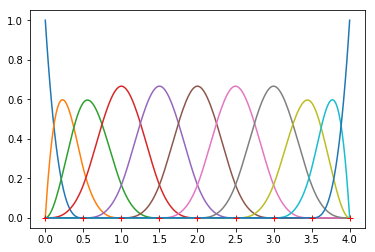

In [4]:
xplot = np.linspace(0., L, 200)

for i in range(spline_space_0.N):
    plt.plot(xplot, spline_space_0(xplot, i))
    
plt.plot(el_b, np.zeros(len(el_b)), 'r+')

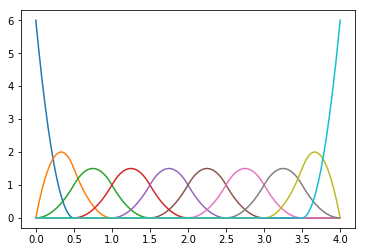

In [5]:
xplot = np.linspace(0., L, 200)

for j in range(spline_space_1.N):
    plt.plot(xplot, p*spline_space_1(xplot, j)/(T1[j + p] - T1[j]))

In [6]:
Np    = np.int(5)
wperp = 0.5
wpar  = 0.2

particles = np.zeros((Np, 5), order='F')
particles[:, 0] = np.random.rand(Np)*L
particles[:, 1] = np.random.randn(Np)*wperp
particles[:, 2] = np.random.randn(Np)*wperp
particles[:, 3] = np.random.randn(Np)*wpar
particles[:, 4] = np.ones(Np)

In [50]:
np.save('particles', particles)

In [7]:
spans = np.floor(particles[:, 0]*Nel/L).astype(int) + p

In [8]:
spans

array([ 8,  3,  9,  8, 10])

In [9]:
jh_x = np.empty(spline_space.N - bc*p, dtype=float)
jh_y = np.empty(spline_space.N - bc*p, dtype=float)

In [10]:
HyCho_PIC_fast.current(particles, T, p, spans, jh_x, jh_y, Nel + p - bc*p, 0)

In [11]:
jh_x

array([-0.27294417,  0.21492069,  0.78055346,  0.1195687 ,  0.        ,
        0.02514529,  0.45728815,  0.39354068])

In [12]:
jh_y

array([ 0.00992807, -0.11717431, -0.3025371 , -0.0463408 ,  0.        ,
        0.04809688,  0.60028859,  0.4039383 ])

In [26]:
jx_test = np.zeros(spline_space.N)
jy_test = np.zeros(spline_space.N)

for ip in range(Np):
    
    #gamma = np.sqrt(1. + particles[ip, 1]**2 + particles[ip, 2]**2 + particles[ip, 3]**2)
    gamma = 1.
    
    for i in range(spline_space.N):
    
        jx_test[i%Nel] -= particles[ip, 1]/gamma*particles[ip, 4]*spline_space(particles[ip, 0], i)
        jy_test[i%Nel] -= particles[ip, 2]/gamma*particles[ip, 4]*spline_space(particles[ip, 0], i)

In [20]:
Np      = np.int(1e6)
pos     = np.random.rand(Np)*L
spans_0 = np.floor(pos*Nel/L).astype(int) + p

res_0   = np.empty(Np, dtype=float)
res_1   = np.empty(Np, dtype=float)

coeff_0 = np.random.rand(Nbase_0)
coeff_1 = np.random.rand(Nbase_1)

pp_0    = np.asfortranarray([[1/6, -1/(2*delta), 1/(2*delta**2), -1/(6*delta**3)], [2/3, 0., -1/delta**2, 1/(2*delta**3)], [1/6, 1/(2*delta), 1/(2*delta**2), -1/(2*delta**3)], [0., 0., 0., 1/(6*delta**3)]])
pp_1    = np.asfortranarray([[1/2, -1/delta, 1/(2*delta**2)], [1/2, 1/delta, -1/delta**2], [0., 0., 1/(2*delta**2)]])

In [21]:
HyCho_PIC_fast.pusher_reflecting(pos, T0, T1, p, spans_0, L, delta, coeff_0, coeff_1, pp_0, pp_1, res_0, res_1)

In [22]:
res_0

array([0.36786468, 0.15498604, 0.41993626, ..., 0.13679368, 0.54629953,
       0.46692294])

In [23]:
res_1

array([0.54758362, 0.76699538, 1.69342656, ..., 3.67022633, 0.82481786,
       0.3612369 ])

In [19]:
res0_test = np.zeros(len(pos), dtype=float)

for ip in range(len(pos)):
    for i in range(spline_space_0.N):
        res0_test[ip] += coeff_0[i%Nbase_0]*spline_space_0(pos[ip], i)
        
        
res1_test = np.zeros(len(pos), dtype=float)

for ip in range(len(pos)):
    for i in range(spline_space_1.N):
        res1_test[ip] += coeff_1[i%Nbase_0]*spline_space_1(pos[ip], i)*p/(T1[i + p] - T1[i])

In [20]:
Lz = 10.


# ... unit test for relativistic boris pusher
test_particle = np.zeros((2, 5), order='F')

test_particle[:, 0] = Lz/2 - 2.62 

gamma = 1/np.sqrt(1 - (0.117**2 + 0.0795**2))

test_particle[:, 1] = 0.117*gamma
test_particle[:, 3] = 0.0795*gamma

spans = np.floor(test_particle[:, 0]*Nel/Lz).astype(int) + p

xi_test = 0.862*0.01

T  = 150.*4
dt = 0.02

pp_0 = np.asfortranarray([[1/6, -1/(2*delta), 1/(2*delta**2), -1/(6*delta**3)], [2/3, 0., -1/delta**2, 1/(2*delta**3)], [1/6, 1/(2*delta), 1/(2*delta**2), -1/(2*delta**3)], [0., 0., 0., 1/(6*delta**3)]])
pp_1 = np.asfortranarray([[1/2, -1/delta, 1/(2*delta**2)], [1/2, 1/delta, -1/delta**2], [0., 0., 1/(2*delta**2)]])

Nt = int(T/dt)

tn = np.linspace(0., T, Nt + 1)

ex = np.zeros(Nbase_0)
ey = np.zeros(Nbase_0)
bx = np.zeros(Nbase_1)
by = np.zeros(Nbase_1)

z_old = np.copy(test_particle[:, 0])
HyCho_PIC_fast.pusher_reflecting(test_particle, dt, T0, T1, p, spans, Lz, delta, ex, ey, bx, by, pp_0, pp_1, xi_test)
test_particle[:, 0] = z_old

positions = np.empty(Nt + 1)
gammas = np.empty(Nt + 1)

positions[0] = test_particle[0, 0]
gammas[0] = gamma

for i in range(Nt):
    HyCho_PIC_fast.pusher_reflecting(test_particle, dt, T0, T1, p, spans, Lz, delta, ex, ey, bx, by, pp_0, pp_1, xi_test)
    positions[i + 1] = test_particle[0, 0]
    gammas[i + 1] = np.sqrt(1 + test_particle[0, 1]**2 + test_particle[0, 2]**2 + test_particle[0, 3]**2)
# ...

omega = 1.*(1 + xi_test*(2.62)**2)
rho = -np.cross(np.array([0.117*gamma, 0., 0.0795*gamma]), np.array([0., 0., 1.]))/omega

B = np.array([-xi_test*rho[0]*(-2.62), -xi_test*rho[1]*(-2.62), (1 + xi_test*(2.62)**2)])

ob = 0.117*np.sqrt(xi_test/np.linalg.norm(B))

phi = np.arctan(0.0795/((Lz/2 - 2.62)*ob))
A = (Lz/2 - 2.62)/np.sin(phi)

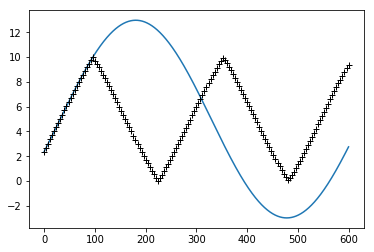

In [21]:
plt.plot(tn, (-2.62*np.cos(ob*tn) + 0.0795/ob*np.sin(ob*tn)) + Lz/2)
plt.plot(tn[0::200], positions[0::200], 'k+')
#plt.ylim((Lz/2 - 4, Lz/2 + 6))
#plt.plot(tn, gammas/gamma + 24.)

In [ ]:
elif rel == 1:
        
        #$ omp parallel
        #$ omp do reduction ( + : jh_x, jh_y ) private ( ip, pos, span, left, right, values, ux, uy, uz, wp_over_gamma, il, i, bi )
        for ip in range(np):
            pos  = particles[ip, 0]
            span = spans[ip]
            basis_funs(knots, degree, pos, span, left, right, values)

            ux = particles[ip, 1]
            uy = particles[ip, 2]
            uz = particles[ip, 3]

            wp_over_gamma = particles[ip, 4]/sqrt(1. + ux**2 + uy**2 + uz**2)

            for il in range(degree + 1):
                i  = (span - il)%n_base
                bi = values[degree - il]*wp_over_gamma

                jh_x[i] -= ux*bi
                jh_y[i] -= uy*bi

        #$ omp end do
        #$ omp end parallel